In [6]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
from glob import glob
import os
import cv2
from openslide import OpenSlide
from skimage.measure import label
import numpy as np
from matplotlib import pyplot as plt

In [2]:
img_files_path = [_ for _ in os.listdir(r'\\fatherserverdw\kyuex\image\CLUE\3D study\he\4xr_jpg') if _.endswith(".jpg")]
img_files_path_png = [x.replace('.jpg','.png') for x in img_files_path]

In [3]:
ndpi = r'\\fatherserverdw\kyuex\image\CLUE\3D study\he\c1'
ndpis = glob(os.path.join(ndpi,'*.ndpi'))

mask = r'\\fatherserverdw\kyuex\image\CLUE\3D study\he\c1\1um\classification_v9_combined'
masks = glob(os.path.join(mask,'*.tif'))

binary_mask = r'\\fatherserverdw\kyuex\image\CLUE\3D study\he\c1\TA'
binary_masks = glob(os.path.join(binary_mask,'*.png'))

### Crop whole slide image, its respective whole slide mask, and then also crop the binary mask together: (note they all have different sizes so you have to use the ratios)

In [ ]:
# for i in range(len(ndpis)):
#     wsi = OpenSlide(ndpis[i])
#     target_level = 4
#     wsi_im = wsi.read_region(location=(0,0),level=target_level,size=wsi.level_dimensions[target_level])
#
#     fn = os.path.basename(ndpis[i])
#     fn,ext = os.path.splitext(fn)
#     TAsrc = r'\\fatherserverdw\kyuex\image\CLUE\3D study\he\c1\TA'
#     TA = os.path.join(TAsrc,fn+'.png')
#     bw = Image.open(TA)
#     labeledbw = label(np.array(bw))
#
#     target_tissue = 4
#     bwtarget = labeledbw == target_tissue
#
#     ind = np.argwhere(bwtarget)
#     margin = 30
#     bbox = [np.min(ind[:,0]),np.min(ind[:,1]),np.max(ind[:,0]),np.max(ind[:,1])] #[miny,minx,maxy,maxx]
#     bboxm = [bbox[0]-margin,bbox[1]-margin,bbox[2]+margin,bbox[3]+margin]
#     bwcropm = bwtarget[bboxm[0]:bboxm[2],bboxm[1]:bboxm[3]]
#
#     wsi_arr = np.array(wsi_im)
#     wsisz = wsi_arr.shape
#     bwsz = bwtarget.shape
#     rsf = wsisz[0]/bwsz[0]
#     bboxm2 = [round(_*rsf) for _ in bboxm]
#     imcropm = wsi_arr[bboxm2[0]:bboxm2[2],bboxm2[1]:bboxm2[3]]
#
#     im_mask = np.array(Image.open(masks[i]))
#     ratio = im_mask.shape[0]/wsi_arr.shape[0]
#     immaskm = im_mask[round(bboxm2[0]*ratio):round(bboxm2[2]*ratio),round(bboxm2[1]*ratio):round(bboxm2[3]*ratio)]
#
#     im_binary_mask = np.array(Image.open(binary_masks[i]))
#     ratio = im_binary_mask.shape[0]/wsi_arr.shape[0]
#     im_binary_mask_m = im_binary_mask[round(bboxm2[0]*ratio):round(bboxm2[2]*ratio),round(bboxm2[1]*ratio):round(bboxm2[3]*ratio)]
#
#     imcropm_src = r'\\fatherserverdw\Kevin\imageregistration2\images'
#     immaskm_src = r'\\fatherserverdw\Kevin\imageregistration2\masks'
#     im_binary_mask_src = r'\\fatherserverdw\Kevin\imageregistration2\binary_mask_wsi'
#
#     Image.fromarray(imcropm).save(os.path.join(imcropm_src,img_files_path_png[i]))
#     Image.fromarray(immaskm).save(os.path.join(immaskm_src,img_files_path_png[i]))
#     Image.fromarray(im_binary_mask_m).save(os.path.join(im_binary_mask_src,img_files_path_png[i]))
#     #save imcropm,immaskm,im_binary_mask_m

### Now, Resize binary masks in binary_mask_wsi to the same size of the padded masks, which is all 5352 x 6328. Then maybe use sci-kit label to only label the actual tissue (exclude the other tissue bits in the edges), and then multiply this binary mask to the padded masks to only find the arrays of the tissue itself.
### Also, compare tissue composition before registration and after registration and see  how much they differ from each other.

In [14]:
binary_mask_files_name = [_ for _ in os.listdir(r'\\fatherserverdw\Kevin\imageregistration2\binary_mask_wsi') if _.endswith(".png")]
bin_mask = r'\\fatherserverdw\Kevin\imageregistration2\binary_mask_wsi'
bin_masks = glob(os.path.join(bin_mask,'*.png'))
im_binary_mask_resized_src = r'\\fatherserverdw\Kevin\imageregistration2\binary_mask_wsi\resized'
padded_mask_ex = Image.open(r'\\fatherserverdw\Kevin\imageregistration2\padded_masks\z0001_1C1.png')
dim_padded_masks = padded_mask_ex.size

In [ ]:
for i in range(len(binary_mask_files_name)):
    temp = cv2.imread(bin_masks[i])
    resize_bin_mask = cv2.resize(temp,dim_padded_masks,interpolation=cv2.INTER_CUBIC)
    resize_bin_mask = cv2.cvtColor(resize_bin_mask, cv2.COLOR_BGR2GRAY)
    tmp_src = os.path.join(im_binary_mask_resized_src,binary_mask_files_name[i])
    cv2.imwrite(tmp_src,resize_bin_mask)

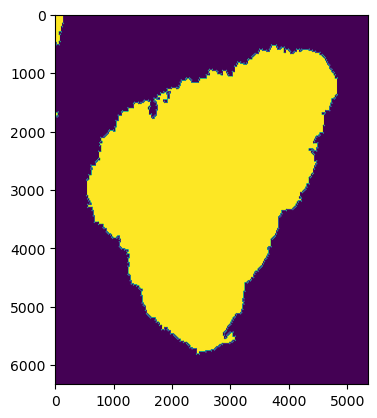

In [110]:
bw = Image.open(os.path.join(im_binary_mask_resized_src,binary_mask_files_name[0]))
ra_bw = np.array(bw)
ra_bw = ra_bw>0
plt.imshow(ra_bw)

In [111]:
ra_bw = ra_bw * 1
ra_bw = ra_bw.astype("uint8")
np.unique(ra_bw,return_counts=True)

(array([0, 1], dtype=uint8), array([20540312, 13327144], dtype=int64))

In [112]:
rsult = np.multiply(ra_bw,padded_mask_ex)
rsult

array([[12, 12, 12, ...,  0,  0,  0],
       [12, 12, 12, ...,  0,  0,  0],
       [12, 12, 12, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [127]:
np.unique(rsult,return_counts=True)
Image.fromarray(rsult).save(r'\\fatherserverdw\Kevin\rsult.png')

(array([0, 1]), array([20660789, 13206667], dtype=int64))

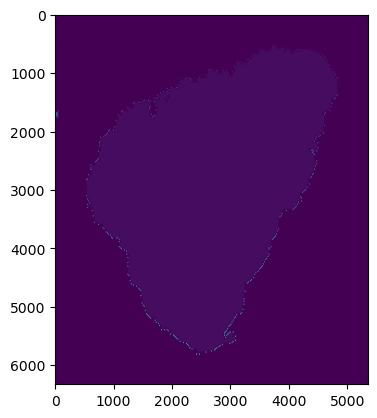

In [121]:
labeledbw = label(np.array(ra_bw))
plt.imshow(labeledbw)
target_tissue = 11
bwtarget = labeledbw == target_tissue
bwtarget = bwtarget*1
np.unique(bwtarget,return_counts=True)

In [122]:
rsult1 = np.multiply(bwtarget,padded_mask_ex)
rsult1
np.unique(rsult1,return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([20660789,   166045,   253878,    66485,    58124,    99016,
          212041,    84078,    45777,   282101,  6048477,   686438,
         5204207], dtype=int64))

In [126]:
Image.fromarray(rsult1).save(r'\\fatherserverdw\Kevin\sample.png')

In [125]:
rsult.shape

(6328, 5352)